# 6. Decision Trees and Ensemble Learning

In this section, we'll talk about decision trees and tree-based ensemble algorithms.

## 6.1 Credit Risk Scoring Project

In the project we'll use credit risk scoring data to make predictions whether the client is eligible for bank load or not. The dataset can be found from this [link](https://github.com/gastonstat/CreditScoring).

Below are the description of the columns in the dataset:

- `Status`: credit status
- `Seniority`: job seniority (years)
- `Home`: type of home ownership
- `Time`: time of requested load
- `Age`: client's age
- `Marital`: marital status
- `Records`: existance of records
- `Job`: type of job
- `Expenses`: amount of expenses
- `Income`: amount of income
- `Assets`: amount of assets
- `Debt`: amount of debt
- `Amount`: amount requested of loan
- `Price`: price of good

To begin, we need to import required libraries for the project:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 6.2 Data Cleaning and Preparation

- Download the dataset
- Re-encoding the categorical variables
- Doing the train/validation/test split

In [2]:
# Dataset url
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

# Download the data
if not os.path.isfile('CreditScoring.csv'):
    !wget $data

In [3]:
# Read the data in dataframe
df = pd.read_csv('CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
# Check the number of rows and columns
df.shape

(4455, 14)

The dataset has 4455 rows and 14 columns but the column names are not in lowercase, we need to deal with it:

In [5]:
# Convert columns to lowercase
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Next thing is to check the data types of these columns.

In [6]:
# Check the columns data type
df.dtypes

status       int64
seniority    int64
home         int64
time         int64
age          int64
marital      int64
records      int64
job          int64
expenses     int64
income       int64
assets       int64
debt         int64
amount       int64
price        int64
dtype: object

We see there is inconsitancey in the data types. For example, columns like `status`, `home`, `marital`, `records`, and `job` are categorical but they are stored as integer. We want to convert them into right data type.

For this purpose, we'll create a list of categorical columns and loop over them to find their unique values:

In [7]:
# List of categorical columns
categorical_cols = ['status', 'home', 'marital', 'records', 'job']

# Check unique values in each of the column
for c in categorical_cols:
    display(df[c].value_counts())

1    3200
2    1254
0       1
Name: status, dtype: int64

2    2107
1     973
5     783
6     319
3     247
4      20
0       6
Name: home, dtype: int64

2    3241
1     978
4     130
3      67
5      38
0       1
Name: marital, dtype: int64

1    3682
2     773
Name: records, dtype: int64

1    2806
3    1024
2     452
4     171
0       2
Name: job, dtype: int64

Some the columns above have `0` values which will set as unknown, for rest of the values we'll replace them with appropiate values using pandas [map()](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) method:

In [8]:
# Map dict for 'status'
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

In [9]:
# Check uniqe values of 'status' after reformatting
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [10]:
# Implement reformatting on rest of the categorical columns
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [11]:
# View the dataframe
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


The columns are correctly formatted, now let's see the summary statistics of the numerical columns.

In [12]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


There is unsual maximum value for `income`, `assets`, and `debt`. We'll replace these values to `NaNs`.

In [13]:
# Replace '99999999' value with 'NaNs'
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

Since we have replace the above values with NaNs, we'll have to take one more step to fill these missing values with `0` so that we can use the data for model.

In [14]:
# Fill missing values with 0
df = df.fillna(0)

In [15]:
# Check the summary statistic again
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,130.0,5346.0,342.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,87.0,11525.0,1244.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,119.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,164.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


The maximum values are changed to the reasonable range. Next, we'll deal with the categorical values one more time. Our target column `status` has three categories `ok`, `default`, and `unk` but we are only intrested to know which in the clients that have the status either ok or default. Therefore, we'll extract the only those rows in the `status` column where we have the values.

In [16]:
# Extract rows of the 'status' column where the value is not 'unk'
df = df[df.status != 'unk'].reset_index(drop=True) # reset index
df.shape

(4454, 14)

Next, we'll split the data into 80% train, 20% validation, and 20% test sets with the random state of 11.

In [17]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [18]:
# Reset the index of train/val/test
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
# Convert target variable 'status' from categorical to binary for train/val/test
y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values

In [20]:
# Drop 'status' column from train/val/test
del df_train['status']
del df_val['status']
del df_test['status']

In [21]:
# Varify the split
df_train.shape[0], df_val.shape[0], df_test.shape[0]

(2672, 891, 891)

In [22]:
df_train.shape[0] + df_val.shape[0] + df_test.shape[0]

4454

In [23]:
y_train.shape, y_val.shape, y_test.shape

((2672,), (891,), (891,))

## 6.3 Decision Trees

- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

In simple words, decision trees make predictions based on the bunch of *if/else* statements. It starts at a single node and then splits in to two or more branches.

To replicate how decision tree works, let's create a function `assess_risk()` that takes a client as the parameter and defines tree based rules accordingly:

In [24]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

Now, let's extract a client from the train dataframe. As we have learnt in the previous sessions that our model will be getting requests in the json/dict format. Therefore, we need convert the pandas series to dictionary.

In [25]:
xi = df_train.iloc[0].to_dict()
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [26]:
# Make prediction using 'assess_risk()' function
assess_risk(xi)

'ok'

Since the client has no records and the assets are more than 6000, the model reponse is ok.

Let's implement this phenomenon on train data and make predictions on validation set using sklearn `DecisionTreeClassifier`. We'll also need to import other classes and methods from sklearn library:

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [28]:
# Convert train dataframe to dictionary
train_dicts = df_train.to_dict(orient='records')
# Instantiate DictVectorizer
dv = DictVectorizer(sparse=False)
# Apply 'dv' to fit and transfrom train data to input X features
X_train = dv.fit_transform(train_dicts)

# Create the decision tree model
dt = DecisionTreeClassifier()
# Train the model
dt.fit(X_train, y_train)

DecisionTreeClassifier()

Our model is trained, next we need to make predictions and evaluate the model on validation set.

In [29]:
# Convert val dataframe to dict
val_dicts = df_val.to_dict(orient='records')
# Apply 'dv' to transform val data to X features
X_val = dv.transform(val_dicts)

# Make predictions on val data
y_pred = dt.predict_proba(X_val)[:, 1]
# Calculate model AUC score on y_val
roc_auc_score(y_val, y_pred)

0.6567411784650409

The model is not performing well on the unseen data. Let's find out the AUC on train data.

In [30]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

Our model performs very well for training data but has poor performance with validation data (unseen data). This is known as overfitting. One of the reasons our model is overfitting cause of it's depth which is increasing the complexity of the model and it is learning all the possible patterns in training data but struggle to match those patterns in the validation data.

One way to overcome this problem is by reducing the number of depth in the decision tree which can be determined using `max_depth` hyperparameter.

In [31]:
# Reduce the max depth to 2 in the model
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [32]:
# Make predictions on train and valiation data
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


Even with only two levels, we can see the slight improvement in the model performance. Let's visualize the model making these predictions:

In [33]:
# Visualize decision tree determines the rules for predictions
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0



D:\repos\ml-engineering\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


From the above tree structure, we can see that when the feature `records` is **yes** (i.e., records=no <= 0.50) and if the `job seniority` is less than or equals to 6.50 years then the client ends up being *default*, but if the `job seniority` is more than 6.50 years then the client is *ok*. 

On the other hand if the client has **no** `records` (i.e., records=no > 0.50) and if the `job` is not partime, in that case the client is *ok*, but the client is *default* if the `job` is partime.

Let's create a decision tree model with only 1 maximum depth and use it to make predictions.

In [34]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.6058644740984719

We see the score has got worst than our first model.

The decision tree with single depth is called **decision stump**. It has only one split.

## 6.4 Decision Tree Learning Algorithm

- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

Let's see how the decision trees come up the rules to make predictions. For that, we'll find the best split with one column on a simple dataset below:

In [35]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


Based on the numerical column `assets`, we want to predict the values in the `status`. We want to try different thresholds to split the dataframe `df_example`. For example, if the condition is true in the assets, we'll have `df_right` but when the condition is false it will become `df_left`. 

The first step is to sort the values of assets to find the number of splits in the dataframe.

In [36]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


From the column `assets`, we can have six potential thresholds, let's make a list of them.

In [40]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

Notice that we don't include the max value `9000` in our thresholds list, this is where the split stops and we don't have any value on the right side of the tree.

Let's see how the our split looks like at threshold 4000.

In [43]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
display(df_right)

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


For column `assets`, the split condition is when the value is above threshold then it'll be `ok` (right side of the tree) and if the value is equal or below to the threshold then it'll end up `default` (left side of the tree).

To see how good our threshold is in terms of splitting the data, we need to calculate its misclassification rate. Classification rate tells us the percentage of incorrect predictions out of total number of predictions.

So at threshold 4000, the misclassification rate is:

- For default:
    - 3 default and 1 ok out of 4 total predictions = 1/4 = 25%
- For ok:
    3 ok and 1 default out of 4 total predictions = 1/4 = 25%
    
We need use pandas `value_counts(normalize=True)` method on `status` to find out the fraction of correct and incorrect predictions. Let's see how we can apply this:

In [44]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_right.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64


Now let's see all the different classification error rates of `status` on all the possible thresholds of `assets`.

In [47]:
for T in Ts:
    print('Threshold:', T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))
    
    print()

Threshold: 0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

Threshold: 2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

Threshold: 3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

Threshold: 4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

Threshold: 5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

Threshold: 8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



We need to take the total average of both left and right misclassification rates to find the best threshold for splitting. The split table for `assets` looks like this:

| T    | Decision Left | Impurity Left | Decision Right | Impurity Right | Avg Misclassification |
|------|---------------|---------------|----------------|----------------|-----|
| 0    | default       | 0%            | ok             | 43%            | 21% |
| 2000 | default       | 0%            | ok             | 33%            | 16% |
| 3000 | default       | 0%            | ok             | 20%            | 10% |
| 4000 | default       | 25%           | ok             | 25%            | 25% |
| 5000 | default       | 50%           | ok             | 50%            | 50% |
| 8000 | default       | 43%           | ok             | 0%             | 21% |

From the table above we can see the best thresholds for `assets` is 3000 where we have the least misclassification rate 10%.

Let's see how can find the best threshold when we have two columns instead:

In [48]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


We have seen the thresholds split for `assets` earlier, now let's see how the split looks like for `debt` column:

In [49]:
# Sort the values by column 'debt'
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


We have the 3 different thresholds (500, 1000, and 2000) for debt. The rule for the `debt` column is when the condition is above threshold, it will end up being `default` (right side of the tree), otherwise its `ok` (left side of the tree).

Let's make a dictionary of all features we have in the dataframe that holds their threshold values respectively.

In [50]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

Next, we'll loop over the `thresholds` dictionary to find the misclassification rates of all features (in our case, `assets` and `debt`).

In [51]:
for feature, Ts in thresholds.items():
    print('#####################')
    print('Feature:', feature)
    for T in Ts:
        print('Threshold:', T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
Feature: assets
Threshold: 0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

Threshold: 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

Threshold: 3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

Threshold: 4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

Threshold: 5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64

Threshold: 8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

#####################
#####################
Feature: debt
Threshold: 500


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64

Threshold: 1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64

Threshold: 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64

#####################


Here's the average misclassification rates for both features in each threshold:

$$Column: Assets$$

| T    | Decision Left | Impurity Left | Decision Right | Impurity Right | Avg Misclassification |
|------|---------------|---------------|----------------|----------------|-----|
| 0    | default       | 0%            | ok             | 43%            | 21% |
| 2000 | default       | 0%            | ok             | 33%            | 16% |
| 3000 | default       | 0%            | ok             | 20%            | 10% |
| 4000 | default       | 25%           | ok             | 25%            | 25% |
| 5000 | default       | 50%           | ok             | 50%            | 50% |
| 8000 | default       | 43%           | ok             | 0%             | 21% |

$$Column: Debt$$

| T    | Decision Left | Impurity Left | Decision Right | Impurity Right | Avg Misclassification |
|------|---------------|---------------|----------------|----------------|-----------------------|
| 500  | ok            | 0%            | default        | 43%            | 21%                   |
| 1000 | ok            | 33%           | default        | 0%             | 16%                   |
| 2000 | ok            | 43%           | default        | 0%             | 21%                   |

From the table above we can clearly see that `debt` is not as helpful as `assets` to bring down the misclassification rate. Therefore, the feature `assets` is a good predictor with the threshold of 3000 that results the least error rate.

Depending on the number of features, that is how the decision tree determines the best thresholds.

## 6.5 Decision Tree Parameter Tuning

- Selecting `max_depth`
- Selecting `min_samples_leaf`

Decision tree has many hyperparameters but the `max_depth` and `min_samples_leaf` are the most important ones when it comes to optimizing the performance.

In the first experiement we'll find the best value for `max_depth`:

In [59]:
# List of depth size
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.760
  10 -> 0.698
  15 -> 0.663
  20 -> 0.656
None -> 0.649


From the above results, we can the best auc score of 76% when the best value of max_depth is `4`, `5`, and `6`. We consider these values for our next experiement which is to find the optimal value of `min_samples_leaf`.

To make the comparison easier, we'll stores the values in `scores` list and create dataframe from it.

In [62]:
# List to store the values of max_depth, min_samples_leaf, and auc
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [63]:
# Create dataframe
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,min_samples_leaf,auc
0,4,1,0.761283
1,4,5,0.761283
2,4,10,0.761283
3,4,15,0.763726
4,4,20,0.760910
5,4,500,0.679842
6,4,100,0.755937
7,4,200,0.747260
8,5,1,0.766496
9,5,5,0.767755


We can use seaborn heatmap function to visualize the table for finding best parameters and auc score. For that purpose we need need pandas `pivot()` method. We'll pivot the table where:

- max_samples_leaf is the index
- max_depth is the column
- auc is the values

In [72]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.754
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.773  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

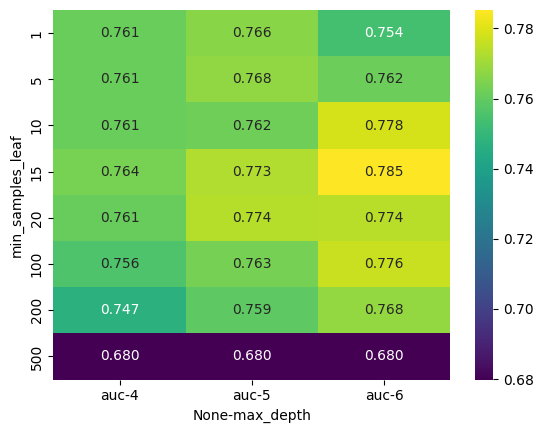

In [78]:
# Display heatmap
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f', cmap='viridis')
plt.show()

The best auc score is 78% when have `max_depth` of 6 and `min_samples_leaf` is 15.

Let's build our final model with these parameters.

In [79]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

We have created the model, now we want to see the text report showing the rules of our decision tree model.

In [80]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- income <= 20.00
|   |   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- seniority >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  20.00
|   |   |   |   |   |--- expenses <= 71.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- expenses >  71.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  4250.00
|   |   |   |   |--- debt <= 1600.00
|   |   |   |   |   |--- seniority <= 2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- seniority >  2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- debt >  1600.00
|   |   |   |   |   |--- class: 1
|   |   |--- income >  74.50
|   |   |   |--- seniority <= 5.50
|   |   |   |   |--- amount <= 1330.00
|   |   |   |   |   |--- assets <= 3326.00
|   |   |   |   |   |   |--- clas

D:\repos\ml-engineering\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 6.6 Ensembles and Random Forest

- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

Random Forest is an example of ensemble learning where each model is a decision tree and their predictions are aggregated to identify the most popular result. Random forest only select a random subset of features from the original data to make predictions.

Let's build our first random forest model with different number of trees (`n_estimators`), ranging from 10 to 200 with incrementation of 10. Another important parameter to set is the `random_state` for reproducibility. If we don't set the random seed than our results will change everytime we train the model because the model choses the features randomnly.

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [83]:
# List to store the estimators and auc values
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    # append the values of estimators and auc scores as tuple in scores list
    scores.append((n, auc))

In [84]:
# Create a dataframe for scores list
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


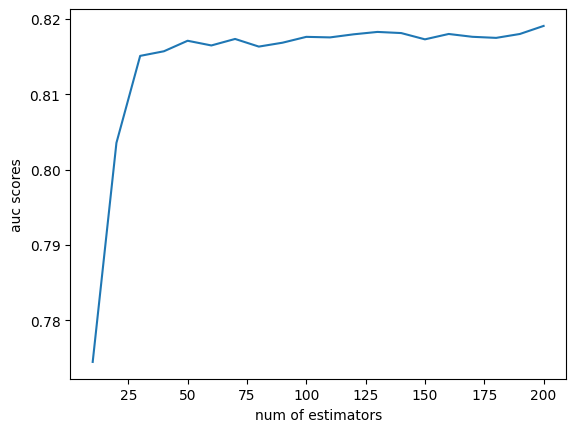

In [86]:
# Plot the 'n_estimators' vs 'auc'
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.xlabel('num of estimators')
plt.ylabel('auc scores')
plt.show()

Although the accuracy is `82%` when we the estimators at `200` but that is not significantly high from the estimators value when is at `50`.